In [1]:
!pip uninstall tensorflow tensorflow-addons keras -y
!pip install tensorflow==2.9.0 keras==2.9.0 tensorflow-addons==0.18.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.3 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installat

In [2]:
import zipfile

In [3]:
import zipfile
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import(ResNet152)
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation, GlobalAveragePooling2D,DepthwiseConv2D, Input, Add, Concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [4]:
main_dir = "/kaggle/input/ctscan/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

Try 3

In [5]:
# zip_path = "/content/drive/MyDrive/train.zip"  # Path to the ZIP file
# extracted_path = "/content/chest_ctscan_images"  # Path to extract the files
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_path)

In [6]:
train_dir = "/kaggle/working/ct-scan/train"
valid_dir = "/kaggle/working/ct-scan/valid"
test_dir = "/kaggle/working/ct-scan/test"

In [7]:
def split_data(source_dir, train_dir, valid_dir, test_dir, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_train_path = os.path.join(train_dir, class_name)
        class_valid_path = os.path.join(valid_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        # Create subdirectories for each class if they don't exist
        os.makedirs(class_train_path, exist_ok=True)
        os.makedirs(class_valid_path, exist_ok=True)
        os.makedirs(class_test_path, exist_ok=True)

        all_files = os.listdir(class_source_path)
        random.shuffle(all_files)  # Shuffle the files randomly

        # Calculate split indices
        train_end = int(len(all_files) * train_ratio)
        valid_end = train_end + int(len(all_files) * valid_ratio)

        # Split the files
        train_files = all_files[:train_end]
        valid_files = all_files[train_end:valid_end]
        test_files = all_files[valid_end:]

        # Move files to respective directories
        for file in train_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_train_path, file))
        for file in valid_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_valid_path, file))
        for file in test_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_test_path, file))


# Call the function to split the data
split_data(main_dir, train_dir, valid_dir, test_dir)


In [8]:
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

In [9]:
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 767 images belonging to 3 classes.


In [11]:
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 219 images belonging to 3 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 111 images belonging to 3 classes.


In [13]:
os.makedirs(test_dir, exist_ok=True)


In [14]:
# Example to list files in the test directory
test_files = os.listdir(test_dir)
print("Number of files in test directory:", len(test_files))

Number of files in test directory: 3


In [15]:
print("Test directory:", test_dir)


Test directory: /kaggle/working/ct-scan/test


In [16]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [17]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=3, average="micro", name='f1_score')
]

In [18]:
base_model = tf.keras.applications.ResNet152(input_shape=(224,224,3),include_top=False,weights="imagenet")

234698864/234698864 [==============================] - 10s 0us/step


In [19]:
total_layers = len(base_model.layers)

In [20]:
num_layers_to_freeze = 0

In [21]:
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = True

In [22]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_1, Trainable: True
Layer 1: conv1_pad, Trainable: True
Layer 2: conv1_conv, Trainable: True
Layer 3: conv1_bn, Trainable: True
Layer 4: conv1_relu, Trainable: True
Layer 5: pool1_pad, Trainable: True
Layer 6: pool1_pool, Trainable: True
Layer 7: conv2_block1_1_conv, Trainable: True
Layer 8: conv2_block1_1_bn, Trainable: True
Layer 9: conv2_block1_1_relu, Trainable: True
Layer 10: conv2_block1_2_conv, Trainable: True
Layer 11: conv2_block1_2_bn, Trainable: True
Layer 12: conv2_block1_2_relu, Trainable: True
Layer 13: conv2_block1_0_conv, Trainable: True
Layer 14: conv2_block1_3_conv, Trainable: True
Layer 15: conv2_block1_0_bn, Trainable: True
Layer 16: conv2_block1_3_bn, Trainable: True
Layer 17: conv2_block1_add, Trainable: True
Layer 18: conv2_block1_out, Trainable: True
Layer 19: conv2_block2_1_conv, Trainable: True
Layer 20: conv2_block2_1_bn, Trainable: True
Layer 21: conv2_block2_1_relu, Trainable: True
Layer 22: conv2_block2_2_conv, Trainable: True
Layer 23: conv2

In [23]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 109,753,219
Trainable params: 109,601,795
Non-trainable params: 151,424
_________________________________________________________________


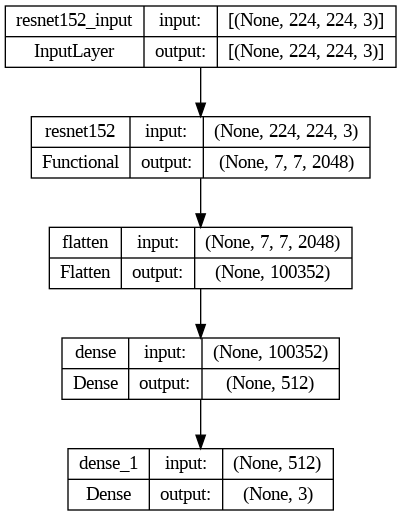

In [24]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [25]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=METRICS
)

In [26]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

In [27]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks,
        verbose=1
    #  , class_weight=class_weights
)

Epoch 1/35
48/48 [==============================] - ETA: 0s - loss: 3.9447 - accuracy: 0.7484 - precision: 0.7743 - recall: 0.7379 - auc: 0.8737 - f1_score: 0.7484 
Epoch 1: val_accuracy improved from -inf to 0.51142, saving model to best_model.keras
48/48 [==============================] - 539s 11s/step - loss: 3.9447 - accuracy: 0.7484 - precision: 0.7743 - recall: 0.7379 - auc: 0.8737 - f1_score: 0.7484 - val_loss: 597977.5625 - val_accuracy: 0.5114 - val_precision: 0.5114 - val_recall: 0.5114 - val_auc: 0.6336 - val_f1_score: 0.5114
Epoch 2/35
48/48 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8553 - precision: 0.8760 - recall: 0.8292 - auc: 0.9658 - f1_score: 0.8553
Epoch 2: val_accuracy improved from 0.51142 to 0.56621, saving model to best_model.keras
48/48 [==============================] - 507s 11s/step - loss: 0.3611 - accuracy: 0.8553 - precision: 0.8760 - recall: 0.8292 - auc: 0.9658 - f1_score: 0.8553 - val_loss: 6898.8687 - val_accuracy: 0.5662 

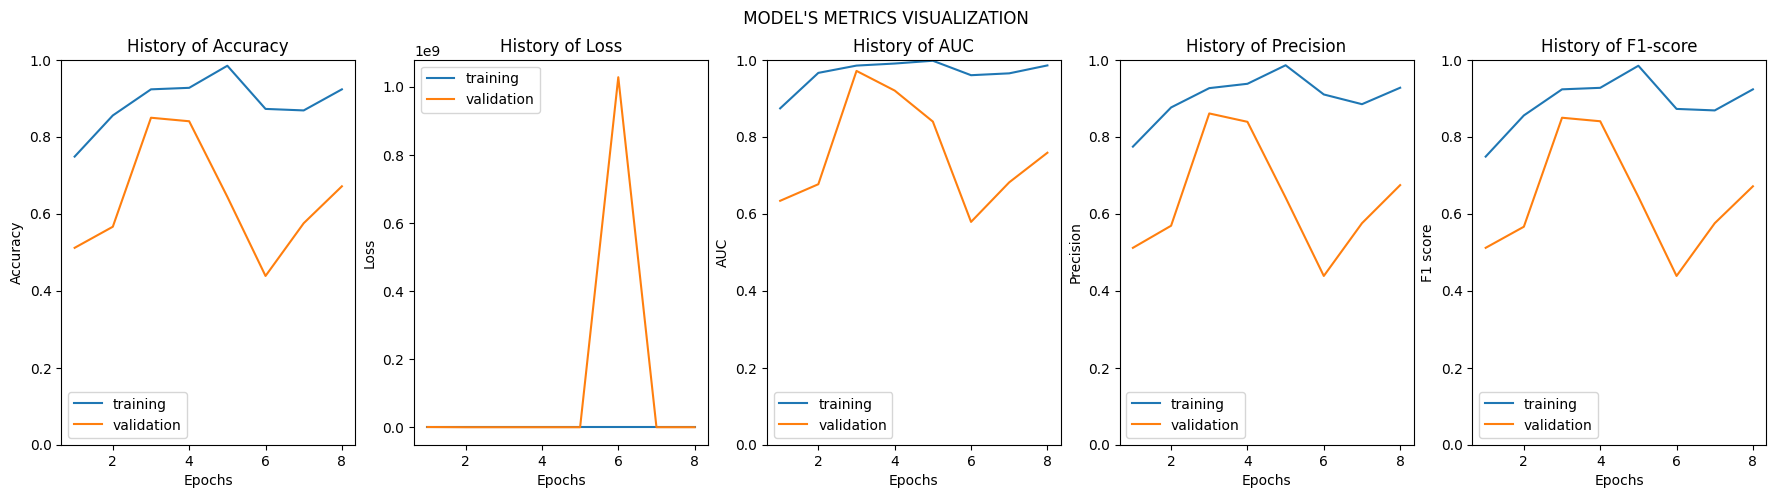

In [28]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss']
               ,
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [29]:
model.evaluate(test_generator)

7/7 [==============================] - 14s 2s/step - loss: 0.2717 - accuracy: 0.8739 - precision: 0.8796 - recall: 0.8559 - auc: 0.9805 - f1_score: 0.8739


[0.2716889977455139,
 0.8738738894462585,
 0.8796296119689941,
 0.8558558821678162,
 0.9805413484573364,
 0.8738739490509033]

In [30]:
# Load the test dataset
X_test, y_test = [], []
for i in range(len(validation_generator)):
    batch_X, batch_y = validation_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

7/7 [==============================] - 32s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.29      0.45        24
           1       0.94      0.90      0.92       112
           2       0.75      0.94      0.83        83

    accuracy                           0.85       219
   macro avg       0.90      0.71      0.73       219
weighted avg       0.87      0.85      0.84       219



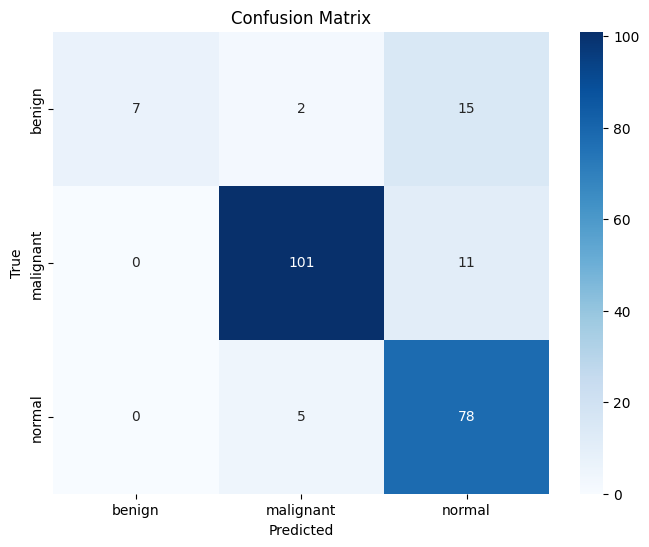

In [31]:
# Correct the variable names
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
class_names = ['benign', 'malignant', 'normal']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()